In [57]:
import json
import os
import torch
import numpy as np
import random
from ast import literal_eval
from dotenv import dotenv_values
from typing import Dict, List, Optional, Union


# Constants
INT_KEYS = [
    "RETRAIN_BATCH", "FORGET_BATCH", "VAL_BATCH", "TEST_BATCH",
    "NUM_CLASSES", "LOCAL_EPOCHS", "MIN_EPOCHS", "MAX_EPOCHS", "LAST_MAX_STEPS"
]


def set_seed(seed: int) -> None:
    """Set random seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def get_device(config: Dict) -> torch.device:
    """Get the appropriate device based on configuration and availability."""
    device_name = config.get("DEVICE", "cuda:0") if torch.cuda.is_available() else "cpu"
    device = torch.device(device_name)
    print(f"Using device: {device}")
    if device.type == 'cuda':
        torch.cuda.set_device(device)
    return device


def load_config(path: str = "./envs") -> Dict:
    """Load and process configuration from environment files."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Configuration directory not found: {path}")

    # Load configuration files
    env_path = os.path.join(path, ".env")
    training_path = os.path.join(path, ".env.training")

    if not os.path.exists(env_path) or not os.path.exists(training_path):
        raise FileNotFoundError(f"Required configuration files missing in {path}")

    config = {
        **dotenv_values(env_path),
        **dotenv_values(training_path),
    }

    # Process configuration values
    try:
        # Handle forget class
        if "FORGET_CLASS" in config:
            config["FORGET_CLASS"] = literal_eval(config["FORGET_CLASS"])

        # Convert integer keys
        for key in INT_KEYS:
            if key in config:
                config[key] = int(config[key])

        # Process comma-separated integer lists
        for key in ["CLIENT_ID_TO_FORGET", "LR_ROUND"]:
            if config[key]:
                config[key] = [int(i) for i in str(config[key]).split(",")]
            else:
                config[key] = []

    except (ValueError, SyntaxError) as e:
        raise ValueError(f"Error parsing configuration: {e}")

    return config


def np_index_save(full_training_index, training_set, retrain_index, forget_index, val_index, test_index, config, partition_id) -> None:
    """Save dataset partition indexes as numpy arrays in an npz file.

    Args:
        full_training_index: Complete training dataset indexes
        forget_index: Indexes of samples to be forgotten
        val_index: Validation dataset indexes
        test_index: Test dataset indexes
        retrain_index: Retrain dataset indexes
        config: Configuration dictionary containing saving directory
    """
    # Create directory if it doesn't exist
    save_path = os.path.join(config["SAVING_DIR"], "partition_indexes")
    os.makedirs(save_path, exist_ok=True)

    # Create the full path for the npz file
    file_path = os.path.join(save_path, f"{partition_id}_dataset_partitions.npz")

    # Save all indexes in a single npz file
    np.savez(
        file_path,
        training_set=training_set,
        full_training=full_training_index,
        forget=forget_index,
        val=val_index,
        test=test_index,
        retrain=retrain_index
    )

    print(f"Dataset partition indexes saved to {file_path}")

def np_index_load(config, partition_id=None) -> tuple:
        """Load dataset partition indexes from an npz file.

        Args:
            config: Configuration dictionary containing saving directory
            partition_id: Optional partition ID. If None, loads without partition ID in filename

        Returns:
            Tuple containing (dictionary of indexes, full_training_index, forget_index,
                             val_index, test_index, retrain_index)
        """
        # Construct the path to the partition_indexes directory
        save_path = os.path.join(config["SAVING_DIR"], "partition_indexes")

        # Check if directory exists
        if not os.path.exists(save_path):
            raise FileNotFoundError(f"Directory not found: {save_path}")

        # Construct the filename based on whether partition_id is provided
        if partition_id is not None:
            file_path = os.path.join(save_path, f"{partition_id}_dataset_partitions.npz")
        else:
            file_path = os.path.join(save_path, "dataset_partitions.npz")

        # Check if file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")

        # Load the npz file
        loaded_data = np.load(file_path)

        # Create the dictionary
        indexes_dict = {
            "training_set": loaded_data["training_set"],
            "full_training_index": loaded_data["full_training"],
            "forget_index": loaded_data["forget"],
            "val_index": loaded_data["val"],
            "test_index": loaded_data["test"],
            "retrain_index": loaded_data["retrain"]
        }

        print(f"Dataset partition indexes loaded from {file_path}")

        # Return both dictionary and individual arrays
        return indexes_dict


def setup_experiment(path: str = "./envs", load_model_flag = True) -> Dict:
    """Set up the experiment with configuration, directories, and model."""
    # Load configuration
    config = load_config(path)

    # Create saving directory
    saving_directory = os.path.join(
        "./checkpoints",
        config["CONFIG_ID"],
        config["MODEL"],
        config["DATASET"],
        f"{config['CONFIG_NUMBER']}_{config['SEED']}"
    )
    os.makedirs(saving_directory, exist_ok=True)
    config["SAVING_DIR"] = saving_directory

    # Save configuration
    config_path = os.path.join(saving_directory, "custom_config.json")
    config["CUSTOM_CONFIG_PATH"] = saving_directory
    if not load_model_flag:
        return config
    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)

    # Load initial model
    config["LOADED_MODEL"] = load_model(config["MODEL"], config.get("RESUME", ""))

    return config


def load_model(model_name: str, checkpoint_path: Optional[str] = None) -> torch.nn.Module:
    """Load a model and initialize from checkpoint if provided."""
    model = get_model(model_name)
    print(f"Model '{model_name}' initialized")

    if not checkpoint_path or checkpoint_path in ("None", ""):
        print("Using freshly initialized model (no checkpoint loaded)")
        return model

    if not os.path.isfile(checkpoint_path):
        print(f"Warning: No checkpoint found at {checkpoint_path}")
        return model

    try:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

        # Handle different checkpoint formats
        if "state_dict" in checkpoint:
            model.load_state_dict(checkpoint["state_dict"])
            print("Successfully loaded model state_dict")
        elif "model" in checkpoint:
            model.load_state_dict(checkpoint["model"])
            print("Successfully loaded model weights")
        else:
            # Try loading directly
            model.load_state_dict(checkpoint)
            print("Successfully loaded model weights directly")

        print(f"Checkpoint loaded from {checkpoint_path}")
    except Exception as e:
        print(f"Error loading checkpoint: {str(e)}")

    return model


def save_model(
        model: torch.nn.Module,
        config: Dict,
        round: Optional[int] = None,
        is_best: bool = False
) -> str:
    """Save model checkpoint to specified path."""
    # Create save directory
    save_dir = os.path.join(config["SAVING_DIR"], "models_chkpts")
    os.makedirs(save_dir, exist_ok=True)

    # Determine filename
    if is_best:
        filename = os.path.join(save_dir, "model_best.pth")
    elif round is not None:
        #filename = os.path.join(save_dir, f"model_round_{round}.pth")
        filename = os.path.join(save_dir, "model_latest.pth")
    else:
        filename = os.path.join(save_dir, "model_latest.pth")

    # Prepare and save checkpoint
    checkpoint = {"state_dict": model.state_dict()}
    torch.save(checkpoint, filename)
    print(f"Model saved to {filename}")

    return filename

In [58]:
indexes_list = []
for i in [0,1,2,3,4]:
    indexes_list.append(np_index_load(setup_experiment("./envs", False), i))

Dataset partition indexes loaded from ./checkpoints/2/ResNet18_small_test/cifar10/2_17/partition_indexes/0_dataset_partitions.npz
Dataset partition indexes loaded from ./checkpoints/2/ResNet18_small_test/cifar10/2_17/partition_indexes/1_dataset_partitions.npz
Dataset partition indexes loaded from ./checkpoints/2/ResNet18_small_test/cifar10/2_17/partition_indexes/2_dataset_partitions.npz
Dataset partition indexes loaded from ./checkpoints/2/ResNet18_small_test/cifar10/2_17/partition_indexes/3_dataset_partitions.npz
Dataset partition indexes loaded from ./checkpoints/2/ResNet18_small_test/cifar10/2_17/partition_indexes/4_dataset_partitions.npz


In [59]:
indexes_list[0]["test_index"]

array([ 314, 1798, 1016, ..., 1813,  268, 1542], shape=(2000,))

In [60]:

indexes_list[0]["full_training_index"]

array([ 376, 7110, 4053, ...,  959, 4192, 4228], shape=(10000,))

In [61]:
indexes_list[0].keys()

dict_keys(['training_set', 'full_training_index', 'forget_index', 'val_index', 'test_index', 'retrain_index'])

In [62]:
for j in [0,1,2,3,4]:
    print(j)
    indexes = indexes_list[j]
    whole = set()
    print("len whole=", len(whole))
    for i in [indexes["val_index"], indexes["training_set"]]:
        print(len(i))
        whole = whole.union(set(i))
        print("len whole=", len(whole))

    print(len(whole))


0
len whole= 0
1000
len whole= 1000
9000
len whole= 10000
10000
1
len whole= 0
1000
len whole= 1000
9000
len whole= 10000
10000
2
len whole= 0
1000
len whole= 1000
9000
len whole= 10000
10000
3
len whole= 0
1000
len whole= 1000
9000
len whole= 10000
10000
4
len whole= 0
1000
len whole= 1000
9000
len whole= 10000
10000


In [63]:
for j in [0,1,2,3,4]:
    print(j)
    indexes = indexes_list[j]
    whole = set()
    print("len whole=", len(whole))
    for i in [indexes["retrain_index"], indexes["forget_index"]]:
        print(len(i))
        whole = whole.union(set(i))
        print("len whole=", len(whole))

    print(len(whole))

0
len whole= 0
8550
len whole= 8550
450
len whole= 9000
9000
1
len whole= 0
8550
len whole= 8550
450
len whole= 9000
9000
2
len whole= 0
8550
len whole= 8550
450
len whole= 9000
9000
3
len whole= 0
8550
len whole= 8550
450
len whole= 9000
9000
4
len whole= 0
8550
len whole= 8550
450
len whole= 9000
9000


In [64]:
for j in ["full_training_index", "test_index"]:
    print(j)
    whole = set()
    print("len whole=", len(whole))
    for i in [0,1,2,3,4]:
        print(len(indexes_list[i][j]))
        whole = whole.union(set(indexes_list[i][j]))

    print(len(whole))

full_training_index
len whole= 0
10000
10000
10000
10000
10000
50000
test_index
len whole= 0
2000
2000
2000
2000
2000
10000


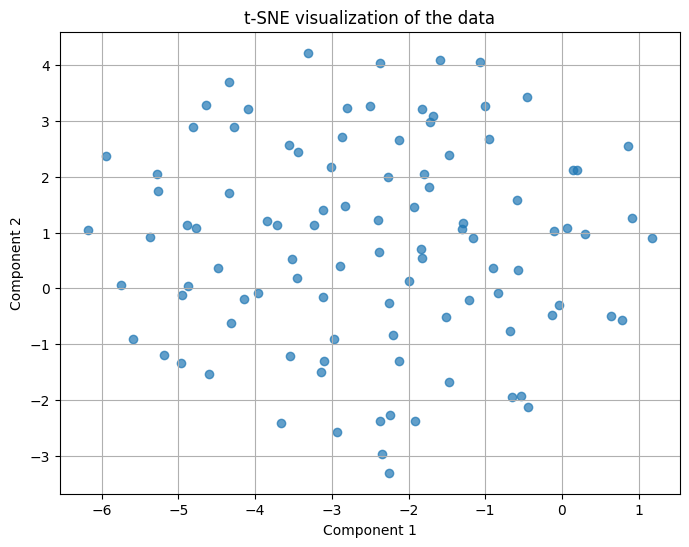

In [1]:
# Import necessary libraries
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Generate a synthetic dataset (100 samples, 50 features)
# In practice, replace this with your actual data matrix X
X = np.random.rand(100, 50)

# Initialize t-SNE with desired parameters
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)

# Fit and transform the data using t-SNE
X_embedded = tsne.fit_transform(X)

# Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.7)
plt.title('t-SNE visualization of the data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()